In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pinnfem import (
    Circ,
    Rect,
    Poly,
    plot_geo,
    exclude_points_in_region,
    plot_prediction,
)

In [2]:
Ω_bc = {"material": "mat1", "mat_val": 0, "bc": "outer"}  # mat1 -> background
Ω = Rect(-1, -1, 2, 2, BC=Ω_bc)
Γ_bc = {"material": "mat2", "mat_val": 10, "bc": "bc_circle1"}  # mat2 -> electrode
Γ = Circ(0.5, 0.5, 0.1, BC=Γ_bc)
Γ_bc = {"material": "mat3", "mat_val": -10, "bc": "bc_circle2"}  # mat2 -> electrode
Γ2 = Circ(-0.5, -0.5, 0.1, BC=Γ_bc)

poly_bc = {"material": "mat3", "mat_val": 5, "bc": "bc_poly1"}  # mat2 -> electrode
ps = [[-0.2, -0.3], [0.4, -0.4], [0.2, 0.2], [0, 0.4]]
poly = Poly(ps, BC=poly_bc)

Got a list of 3 geometries.


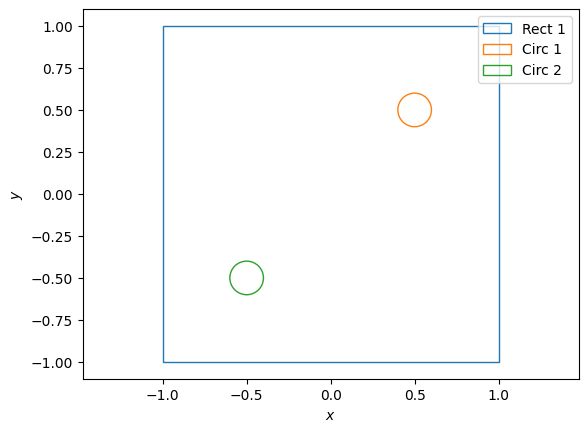

In [3]:
plot_geo([Ω, Γ, Γ2])

In [4]:
from netgen.geom2d import CSG2d, Circle, Rectangle
from ngsolve.webgui import Draw
from ngsolve import Mesh, VOL, H1, GridFunction, BilinearForm


def create_geo_component(geometry):
    if geometry.geo_type == "Rect":
        domain = Rectangle(
            pmin=(geometry.x_min, geometry.y_min),
            pmax=(geometry.x_max, geometry.y_max),
            mat=geometry.BC["material"],
            bc=geometry.BC["bc"],
        )
    elif geometry.geo_type == "Circ":
        domain = Circle(
            center=(geometry.x, geometry.y),
            radius=geometry.r,
            mat=geometry.BC["material"],
            bc=geometry.BC["bc"],
        )
    return domain


def wrap_to_mesh(main, interior_s, refinement=0.05, draw=False):
    if isinstance(interior_s, list):
        print(f"Got a list of {len(interior_s)} geometries.")
    else:
        interior_s = [interior_s]

    geo = CSG2d()

    regionCFf_dict = {main.BC["material"]: main.BC["mat_val"]}
    background = create_geo_component(main)

    for ints in interior_s:
        regionCFf_dict[ints.BC["material"]] = ints.BC["mat_val"]
        sub_domain = create_geo_component(ints)
        background = background - sub_domain  # "-" is subtsraction, "*" is union
    geo.Add(background)

    mesh = geo.GenerateMesh(maxh=refinement)
    mesh = Mesh(mesh)
    # curve the mesh elements for geometry approximation of given order
    mesh.Curve(3)
    print("boundaries:", mesh.GetBoundaries())
    # cf = mesh.RegionCF(VOL, regionCFf_dict)
    if draw:
        # Draw(cf, mesh)
        Draw(mesh)
    return mesh

In [5]:
mesh = wrap_to_mesh(Ω, [Γ, Γ2])

Got a list of 2 geometries.
boundaries: ('outer', 'outer', 'outer', 'outer', 'bc_circle2', 'bc_circle2', 'bc_circle2', 'bc_circle2', 'bc_circle1', 'bc_circle1', 'bc_circle1', 'bc_circle1')


In [6]:
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## 2D

In [7]:
from netgen.geom2d import CSG2d, Circle, Rectangle
from ngsolve import Mesh
from ngsolve.webgui import Draw

In [8]:
geo = CSG2d()

# el1 = Rectangle(pmin=(-1.5,-0.5), pmax=(-1,0.5), bc = "bc_el1", mat = "el_mat")
# el2 = Rectangle(pmin=(1.5,-0.5), pmax=(1.5,0.5), bc = "bc_el2", mat = "el_mat")

el1 = Circle(center=(1.5, 0), radius=0.3, bc="bc_el1", mat="el_mat")
el2 = Circle(center=(-1.5, 0), radius=0.3, bc="bc_el2", mat="el_mat")

domain = Rectangle(pmin=(-3, -2), pmax=(3, 2), bc="default", mat="air") - el1 - el2

geo.Add(domain)
geo.Add(el1)
geo.Add(el2)

mesh = Mesh(geo.GenerateMesh(maxh=0.2))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [9]:
from collections import defaultdict
from ngsolve import CoefficientFunction

In [10]:
print(mesh.GetMaterials())

('air', 'el_mat', 'el_mat')


In [11]:
diel_perm = defaultdict(lambda: -1)  # -1 is default
# all diel_perm["unknwn"] = -1
diel_perm["air"] = 1.0
diel_perm["el_mat"] = 5.0

diel_perm_cf = CoefficientFunction([diel_perm[mat] for mat in mesh.GetMaterials()])
# diel_perm_cf = CoefficientFunction([diel_perm[mat] for mat in mesh.GetMaterials()])

In [12]:
print(mesh.GetBoundaries())

('default', 'default', 'default', 'default', 'bc_el2', 'bc_el2', 'bc_el2', 'bc_el2', 'bc_el1', 'bc_el1', 'bc_el1', 'bc_el1', 'bc_el1', 'bc_el1', 'bc_el1', 'bc_el1', 'bc_el2', 'bc_el2', 'bc_el2', 'bc_el2')


In [13]:
voltage = 4

potential = defaultdict(lambda: 0)

potential["bc_el1"] = voltage
# potential["bc_el2"] = -voltage

potential_cf = CoefficientFunction([potential[bnd] for bnd in mesh.GetBoundaries()])
potential_str = "bc_el1"  # |bc_el2" #|bc_el2 ,...

In [14]:
Draw(potential_cf, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [15]:
dirichlet_str = "air|bc_el1|bc_el2"

In [16]:
from ngsolve import H1, BilinearForm, grad, dx, GridFunction, Grad

In [17]:
fes = H1(mesh, order=2, dirichlet=dirichlet_str)
ut, vt = fes.TnT()
a = BilinearForm(fes)

a += diel_perm_cf * grad(ut) * grad(vt) * dx
a.Assemble()
u = GridFunction(fes, name="Potential")
u.Set(potential_cf, definedon=mesh.Boundaries(potential_str))
f = u.vec.CreateVector()
f.data = a.mat * u.vec
u.vec.data -= a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky") * f

In [18]:
Draw(u)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [ ]:
# E = -Grad(u)
# Draw(E, mesh, "E")